## Imports

In [1]:
from scipy.optimize import brentq
from simulib.cash_flow_models import *
from simulib.visualize import *

## Calc LCOE given net CAPEX (Gov't support - CAPEX)

In [2]:
a = get_discounted_power_production(
        wind_annual_power_production = 69032.25,
        t_construction = 2, LT_field = 26,
        discount_rate = 0.06
    ),
b = net_present_value([0, 9] + 25*[100], 0.06)

print(b/a*1000*1000)

[1458.79701826]


## Simulation Results

In [3]:
W = 1000 # number of simulation paths

In [4]:
wc_simulation = MonteCarlo(WindContractorPath, 1)
fo_simulation = MonteCarlo(FieldOperatorPath, W)

WindContractorPath Simulation complete at 0 ms
FieldOperatorPath Simulation complete at 35 ms


### Gas

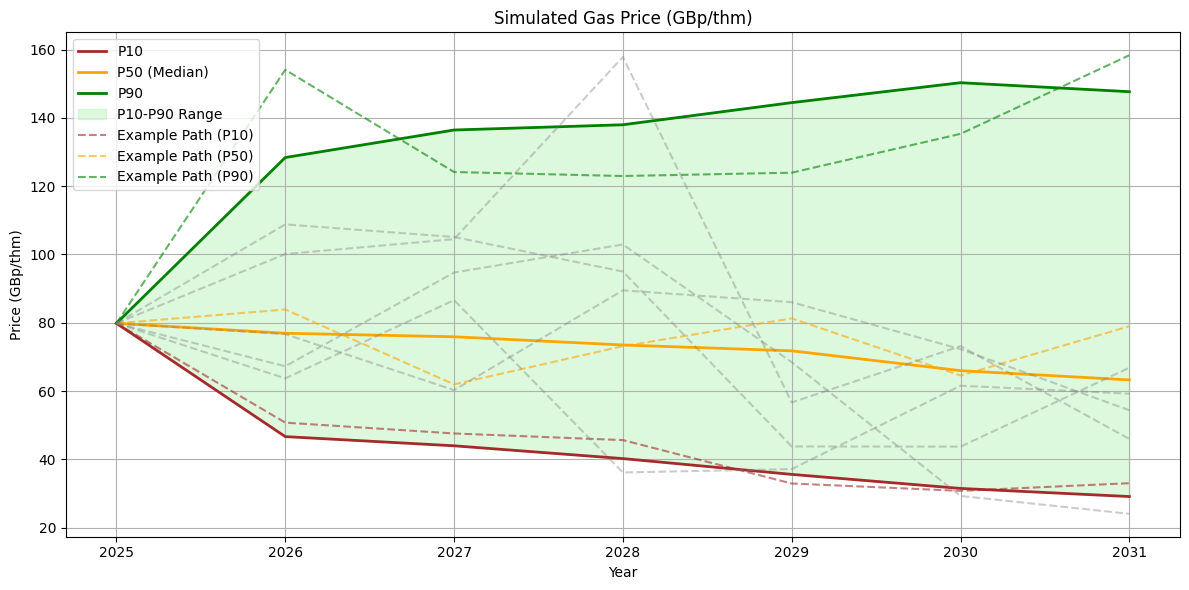

In [5]:
years = np.arange(2025, 2032)
num_paths = W
state_variable_paths = np.array([path.state_variables["P_gas"] for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    state_variable_paths, 
    title="Simulated Gas Price (GBp/thm)", 
    ylabel="Price (GBp/thm)"
)


### Carbon

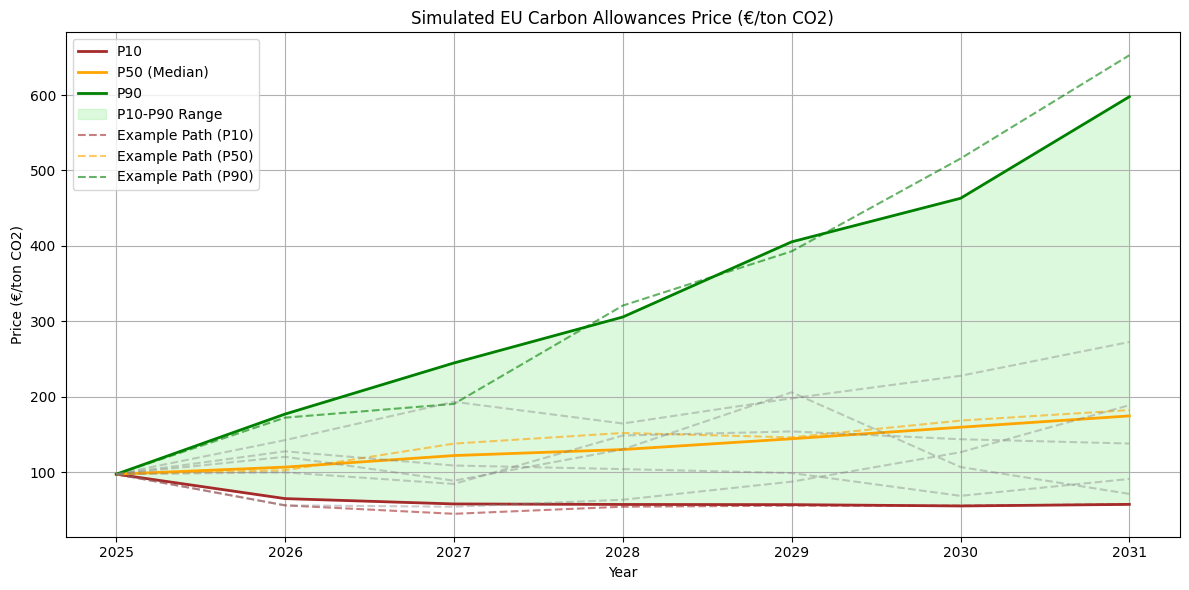

In [6]:
years = np.arange(2025, 2032)
num_paths = W
state_variable_paths = np.array([path.state_variables["P_ets"] for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    state_variable_paths, 
    title="Simulated EU Carbon Allowances Price (€/ton CO2)", 
    ylabel="Price (€/ton CO2)"
)


## Standard Case Results

In [7]:
# kwargs["CAPEX_support"] = 2000 * 10**6

In [8]:
ppa_price = 2000 # kr/MWh basert på utsira Nord "high"-case

In [9]:
npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)
npv_fo = fo_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)
print_currency_array("NPV WC", npv_wc)
print_currency_array("NPV FO", npv_fo)
print("NPV FO", f"{int(np.mean(npv_fo) / 1e6):,}".replace(",", " "))
print("NPV Net:", f"{int((np.mean(npv_wc) + np.mean(npv_fo)) / 1e6):,}".replace(",", " "))

NPV WC ['414']
NPV FO ['513', '577', '576', '331', '457', '489', '359', '365', '410', '795', '627', '470', '560', '596', '419', '1 042', '942', '645', '754', '442', '402', '430', '756', '468', '899', '614', '444', '445', '430', '357', '486', '489', '524', '292', '770', '558', '435', '625', '1 288', '655', '315', '387', '1 203', '305', '360', '529', '580', '639', '559', '713', '398', '739', '621', '634', '473', '876', '371', '491', '306', '700', '407', '658', '604', '905', '454', '550', '339', '484', '636', '306', '730', '566', '479', '346', '569', '543', '355', '524', '354', '560', '614', '959', '417', '880', '311', '330', '490', '613', '757', '359', '445', '534', '430', '636', '645', '556', '400', '365', '474', '402', '543', '334', '922', '451', '556', '376', '580', '797', '315', '608', '641', '511', '455', '269', '1 060', '456', '898', '547', '634', '451', '482', '420', '521', '425', '721', '916', '635', '597', '1 266', '715', '535', '521', '471', '397', '564', '495', '476', '385', '

### Wind Contractor Cash Flows

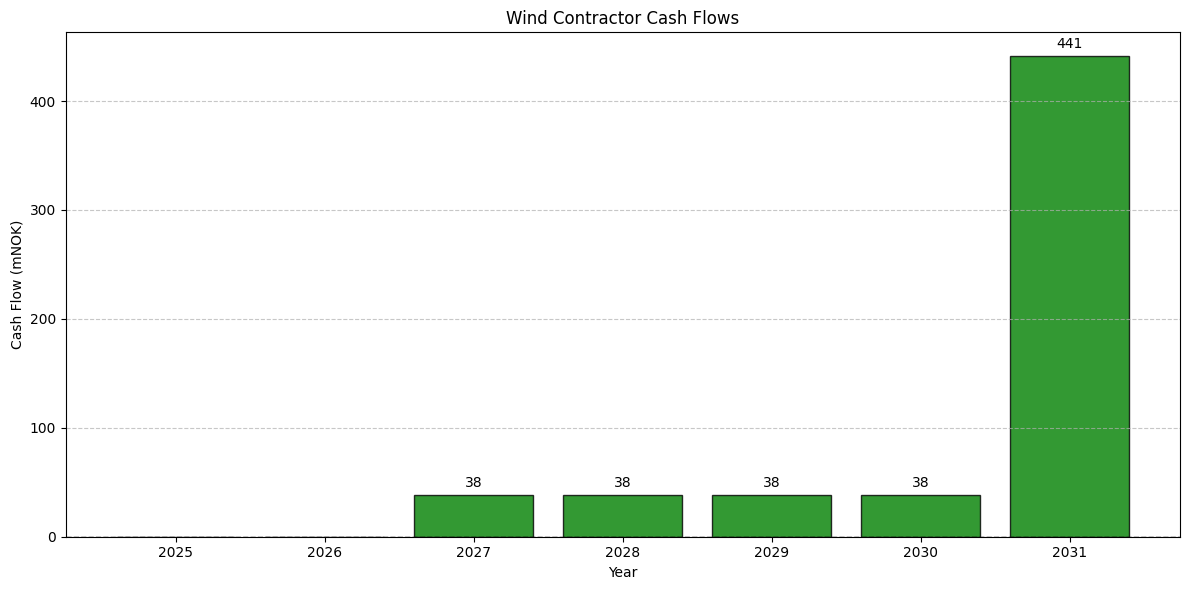

In [10]:
years = np.arange(2025, 2032)
num_paths = W
cash_flows = wc_simulation.paths[0].cash_flows/1000000

# Call the function
plot_cash_flows(
    years, 
    cash_flows, 
    title="Wind Contractor Cash Flows", 
    ylabel="Cash Flow (mNOK)"
)


### Field Operator Cash Flows

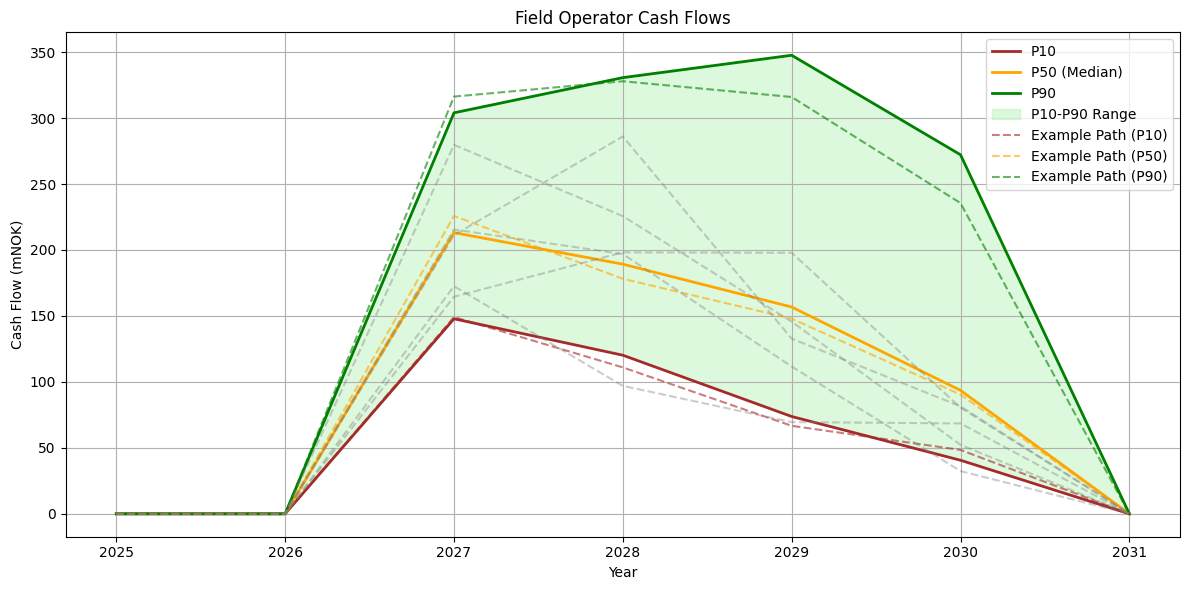

In [11]:
years = np.arange(2025, 2032)
num_paths = W
state_variable_paths = np.array([path.cash_flows/1000000 for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    state_variable_paths, 
    title="Field Operator Cash Flows", 
    ylabel="Cash Flow (mNOK)"
)


In [12]:
state_variable_paths.shape

(1000, 7)

In [13]:
years

array([2025, 2026, 2027, 2028, 2029, 2030, 2031])

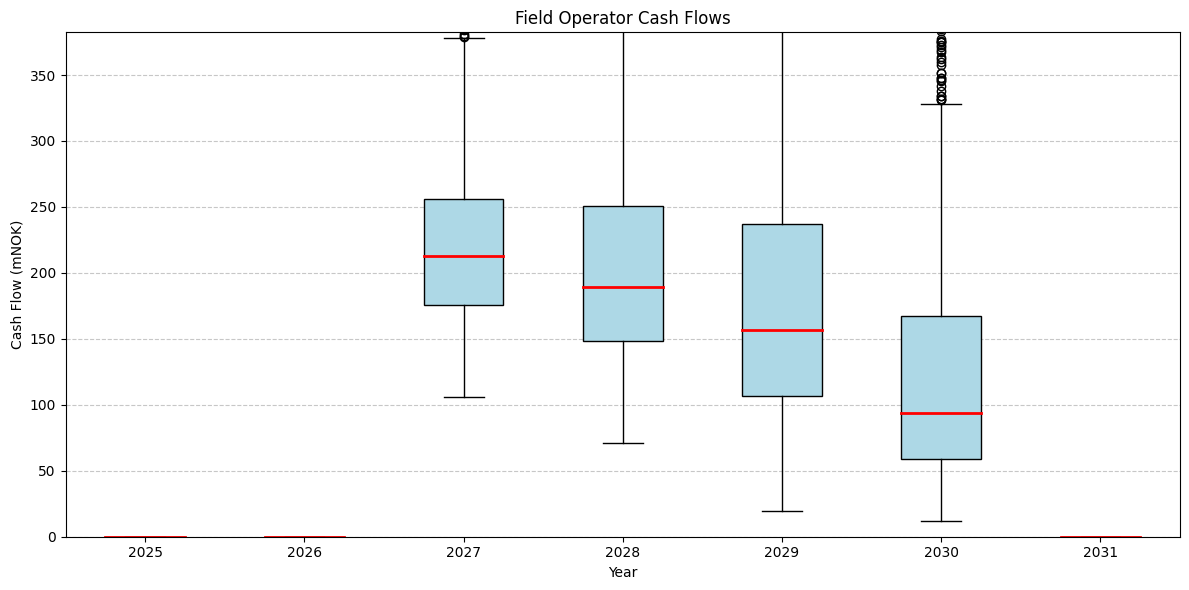

In [14]:
years = np.arange(2025, 2032)
num_paths = W
state_variable_paths = np.array([path.cash_flows/1000000 for path in fo_simulation.paths])

# Call the function
plot_state_variable_boxplots(
    years, 
    state_variable_paths, 
    title="Field Operator Cash Flows", 
    ylabel="Cash Flow (mNOK)"
)


# Sensitivity Analyses

## CAPEX

In [25]:
CAPEX_low = 000 * 10**6
CAPEX_high = 5000 * 10**6

### Wind Operator

In [26]:
def objective(CAPEX):
    kwargs_copy = kwargs.copy()
    kwargs_copy["CAPEX"] = CAPEX
    npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
    return npv

zero_level = brentq(objective, CAPEX_low, CAPEX_high)

In [27]:
int(zero_level/1000000)

2428

### Net Project

In [36]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(CAPEX):
        kwargs_copy = kwargs.copy()
        kwargs_copy["CAPEX"] = CAPEX
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        return (npv_wc + npv_fo)

    zero_levels.append(brentq(objective, CAPEX_low, CAPEX_high)/1000000)

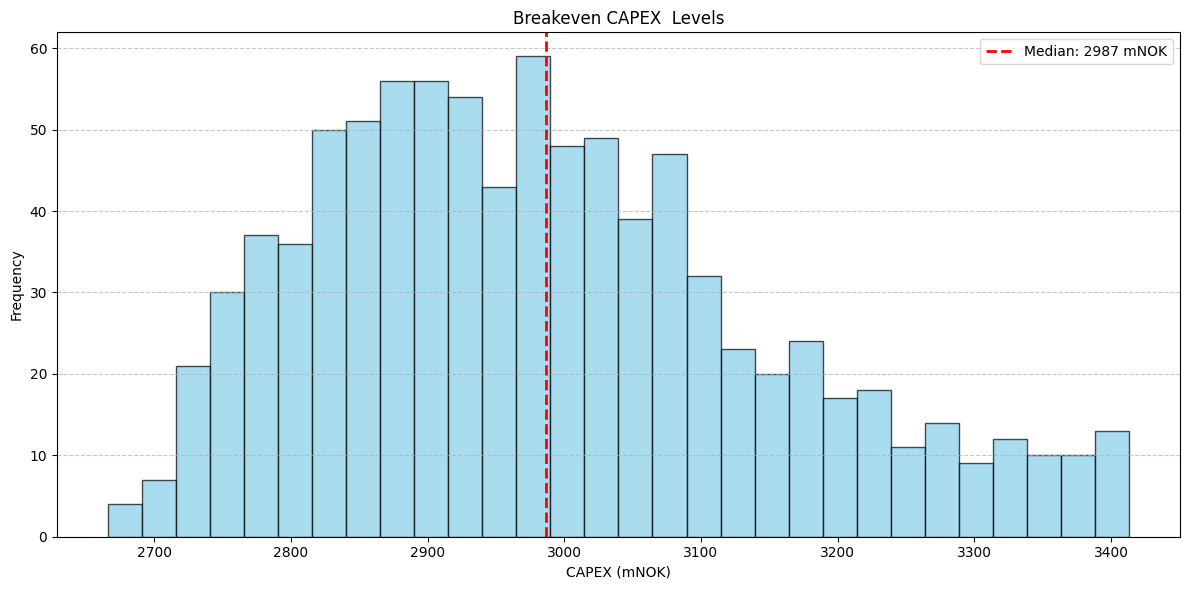

In [37]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven CAPEX  Levels", 
    xlabel="CAPEX (mNOK)"
)

## PPA-price

In [83]:
kwargs["CAPEX"] = 3000 * 10**6

In [84]:
ppa_low = 0
ppa_high = 100000

### Wind Contractor

In [85]:
def objective(ppa_price):
    kwargs_copy = kwargs.copy()
    # kwargs_copy["CAPEX"] = CAPEX
    npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
    return npv

zero_level = brentq(objective, ppa_low, ppa_high)
zero_level

4530.251262460496

### Field Operator

In [86]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        # kwargs_copy["CAPEX"] = CAPEX
        npv = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        return npv

    zero_levels.append(brentq(objective, ppa_low, ppa_high))

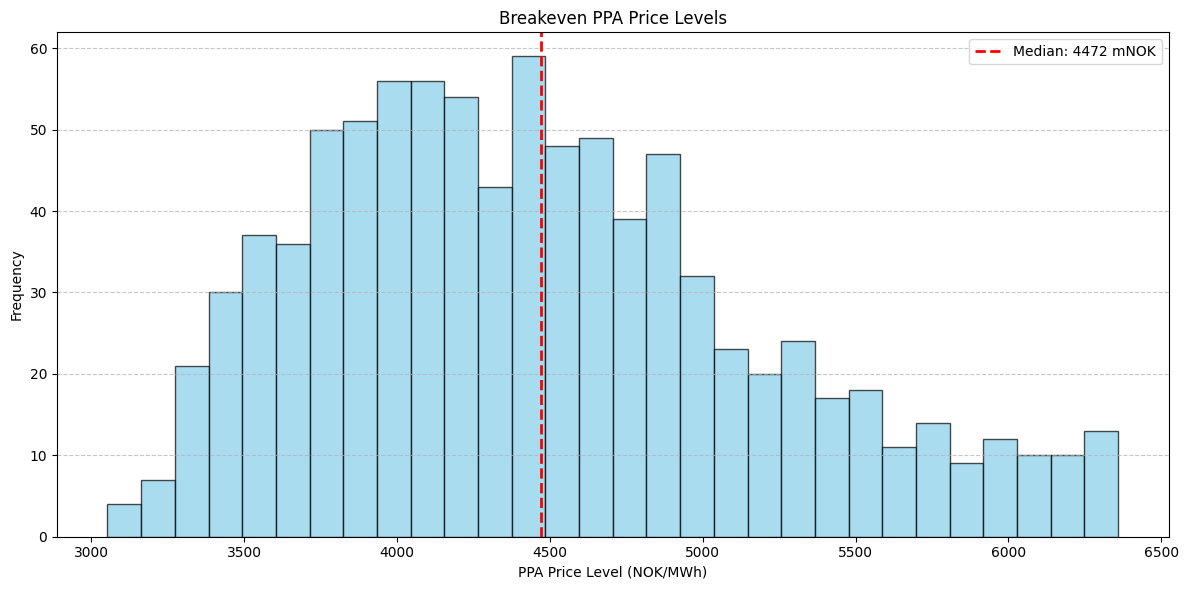

In [87]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven PPA Price Levels", 
    xlabel="PPA Price Level (NOK/MWh)"
)

### Net Project

In [92]:
zero_levels = []

num_npv_negative = 0

for path in fo_simulation.paths:
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        print(npv_wc, npv_fo, npv_wc + npv_fo)
        return (npv_wc - npv_fo)
    
    zero_levels.append(brentq(objective, ppa_low, ppa_high))
    # except ValueError:
    #     num_npv_negative += 1
    #     continue


-989994598.5926119 950904505.5887824 -39090093.00382948
20862978696.644005 -20902068789.64783 -39090093.00382614
-19545046.50191486 -19545046.501914605 -39090093.003829464
-19545046.501914263 -19545046.50191518 -39090093.00382944
-989994598.5926119 1014460311.1761925 24465712.583580613
20862978696.644005 -20838512984.060425 24465712.583580017
12232856.291790128 12232856.291790292 24465712.58358042
12232856.291790724 12232856.291789725 24465712.58358045
-989994598.5926119 1013990496.0622044 23995897.469592452
20862978696.644005 -20838982799.17441 23995897.469593048
11997948.734795868 11997948.73479648 23995897.469592348
11997948.734796643 11997948.734795734 23995897.469592378
-989994598.5926119 768774337.8219974 -221220260.7706145
20862978696.644005 -21084198957.41462 -221220260.77061462
-110610130.38530731 -110610130.38530716 -221220260.77061448
-110610130.38530684 -110610130.38530773 -221220260.77061456
-989994598.5926119 894312659.84054 -95681938.75207186
20862978696.644005 -20958660

In [93]:
num_npv_negative

0

In [94]:
zero_levels

[4440.812419343551,
 4586.229257429523,
 4585.1543119114895,
 4024.0952859215167,
 4311.329247914932,
 4384.05836139896,
 4086.968089541513,
 4100.411956573524,
 4205.024977825083,
 5085.894090137535,
 4701.603438457658,
 4341.619074694748,
 4547.559115659442,
 4630.480438666308,
 4224.872392076101,
 5649.746282394156,
 5420.474569891922,
 4741.308129157675,
 4991.288419357411,
 4278.152007467919,
 4186.739353659512,
 4250.790066521948,
 4996.928299790564,
 4337.817052980936,
 5323.723533972344,
 4671.454711147544,
 4282.33200650211,
 4284.100923173187,
 4250.027641670166,
 4082.564159396296,
 4379.351164938203,
 4384.158978064463,
 4464.10886994625,
 3934.9746211424804,
 5026.904996699782,
 4543.704991831293,
 4260.736624554929,
 4696.091970157786,
 6212.66922536422,
 4764.566712771723,
 3986.240684037095,
 4152.181365429566,
 6019.137526737999,
 3965.1072466522255,
 4089.021309594356,
 4476.173904275212,
 4593.712801929018,
 4728.918401637081,
 4545.846943267679,
 4898.737489176941,


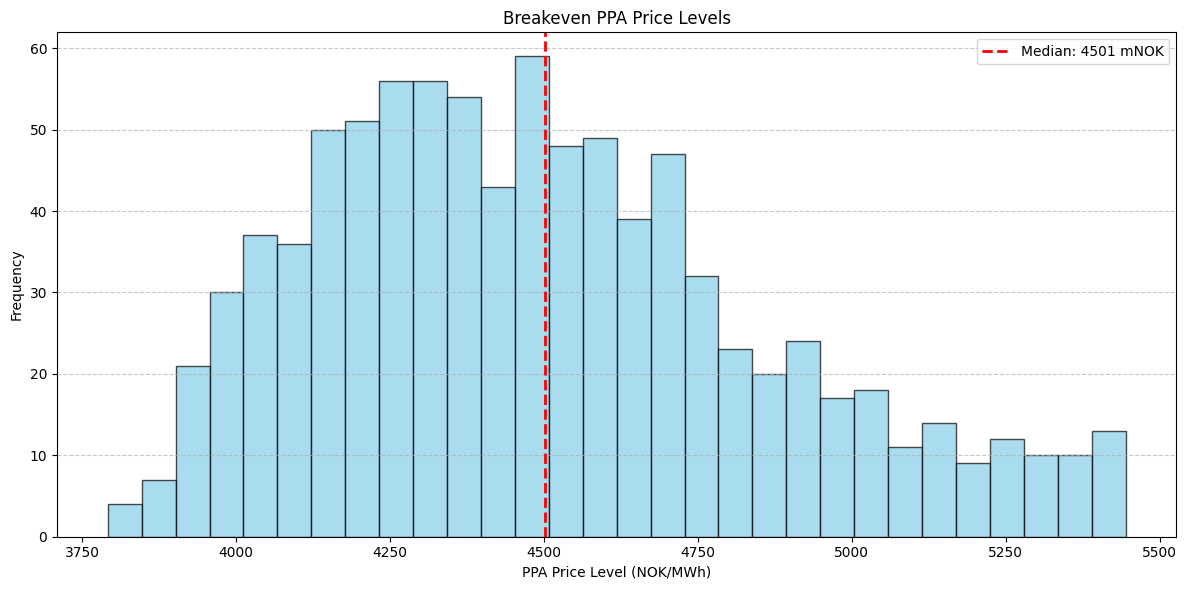

In [95]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven PPA Price Levels", 
    xlabel="PPA Price Level (NOK/MWh)"
)

# Old shit

In [12]:
net_present_value([0.e+00,  0.e+00, -1.e+08, -1.e+08, -1.e+08, -1.e+08,  1.e+09], 0.07)

349780424.14698666

In [10]:
objective(000)

[ 0.e+00  0.e+00 -1.e+08 -1.e+08 -1.e+08 -1.e+08  1.e+09]


349780424.14698666

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:


plt.figure(figsize=(10, 6))
plt.hist(data, bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("title")
plt.xlabel("xlabel")
plt.ylabel("ylabel")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

